# Imports

In [1]:
%%capture
!git clone https://github.com/vinhhoanglong/Stock-Prediction-Deep-Learning.git
%cd Stock-Prediction-Deep-Learning


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import operator
from datetime import datetime

In [3]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []

    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.05*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

def string_to_time(date):

    date = datetime.strptime(date, '%Y-%m-%d')
    date = datetime.timestamp(date)
    return date

def normalize(x, min, max):
    return (x - min)/(max - min)

def reverse_normalize(y, min, max):
    return y*(max - min) + min

def min_max_dic(dataset):
    dic = {}
    for col in dataset.columns:
        dic[col] = [dataset[col].min(), dataset[col].max()]
        dataset[col] = dataset[col].apply(lambda x: normalize(x, dic[col][0], dic[col][1]))
    return dic

In [4]:

# Here we define our model as a class
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(device)
        c0 = c0.to(device)
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out


# Define CUDA

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
print(device)

cuda


# Load Dataset

In [7]:
data = pd.read_csv('data/processed/apple.csv')

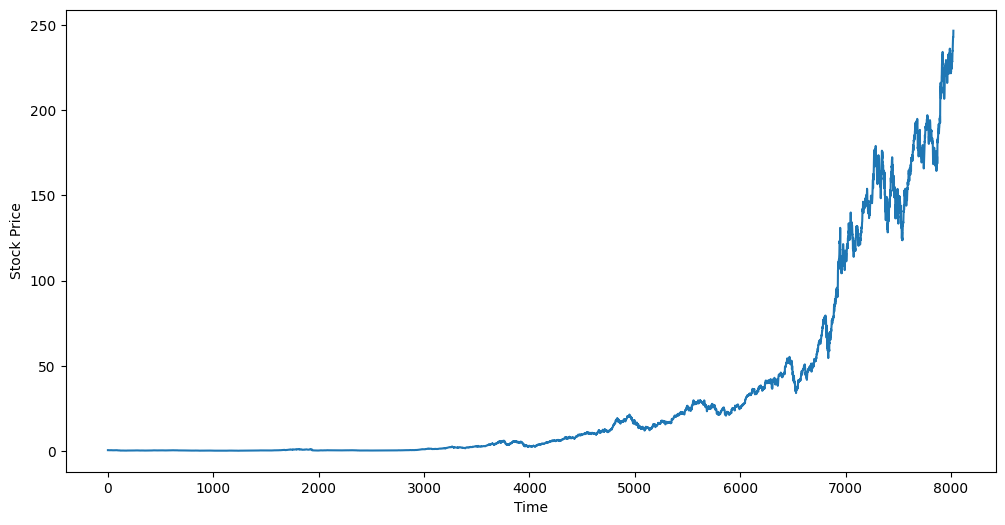

In [8]:
#Close is stock price at the end of that day
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(data))), data['Close'])
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

# Proprocess Dataset

In [9]:
from datetime import datetime

def string_to_time(date):
    date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S%z')
    date = datetime.timestamp(date)
    return date

In [10]:
#normalize dataset and keep track of close value
data['Date'] = data['Date'].apply(lambda x: string_to_time(x))
min_max_dictionary = min_max_dic(data)
display(data)

stock_value = data[['Close']]

<ipython-input-3-682ac70b77f5>:27: RuntimeWarning: invalid value encountered in scalar divide
  return (x - min)/(max - min)
<ipython-input-3-682ac70b77f5>:27: RuntimeWarning: invalid value encountered in scalar subtract
  return (x - min)/(max - min)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,pct_change_APPLE,log_change_APPLE,...,fft_imag_APPLE,fft_magnitude_APPLE,fft_phase_APPLE,IBM_close,INTC_close,MSFT_close,QCOM_close,SPY_close,TXN_close,target
0,0.000000,0.001394,0.001394,0.001371,0.001355,0.032720,0.0,0.0,0.602169,0.712049,...,0.999299,0.000812,0.856939,0.004656,0.005561,0.000642,0.000000,0.000510,0.000447,0.001400
1,0.000258,0.001365,0.001394,0.001379,0.001406,0.029267,0.0,0.0,0.644091,0.746690,...,0.999291,0.000831,0.862069,0.005215,0.006859,0.000683,0.000065,0.000810,0.000852,0.001371
2,0.000344,0.001409,0.001401,0.001409,0.001377,0.021397,0.0,0.0,0.590342,0.702051,...,0.999258,0.000808,0.864019,0.004966,0.006859,0.000745,0.000140,0.000900,0.000745,0.001364
3,0.000430,0.001417,0.001387,0.001357,0.001369,0.032462,0.0,0.0,0.604652,0.714135,...,0.999292,0.000837,0.862935,0.004469,0.006174,0.000719,0.000259,0.001350,0.000703,0.001349
4,0.000516,0.001387,0.001365,0.001371,0.001355,0.024887,0.0,0.0,0.599737,0.710001,...,0.999272,0.000865,0.871412,0.004866,0.006282,0.000580,0.000475,0.001530,0.000703,0.001283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,0.999484,0.982861,0.981873,0.986655,0.983377,0.002002,0.0,0.0,0.624537,0.730684,...,0.442489,0.422035,0.246779,0.961228,0.345836,0.925528,0.718913,0.993316,0.894404,0.980781
8019,0.999570,0.995408,0.987335,0.996364,0.984837,0.002749,0.0,0.0,0.611272,0.719675,...,0.282836,0.548669,0.272424,0.980485,0.337414,0.938921,0.722286,0.999743,0.891748,0.980902
8020,0.999656,1.000000,0.989075,1.000000,0.984959,0.002161,0.0,0.0,0.609673,0.718340,...,0.153902,0.679045,0.303389,0.985889,0.318258,0.950118,0.712918,0.998029,0.874988,0.980095
8021,0.999742,0.995572,0.989439,0.999793,0.984148,0.001733,0.0,0.0,0.608561,0.717411,...,0.084473,0.803998,0.334245,1.000000,0.320239,0.952163,0.708993,1.000000,0.875492,0.995882


In [11]:
#split data into training and testing components
X_train, y_train, X_test, y_test = split_data(stock_value, 20)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Initialize Hyperparameters

In [12]:
input_size = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
epochs = 400

# Define Model (GRU)

In [13]:
model = LSTM(input_size, hidden_dim, num_layers, output_dim).to(device)
loss_func = nn.MSELoss(reduction='mean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model

In [14]:
train_loss = []
min_loss = np.Inf

for epoch in range(epochs):
    #zero out gradients
    optimizer.zero_grad()

    pred = model(X_train.to(device))
    loss = loss_func(pred, y_train.to(device))
    train_loss.append(loss.item())
    print('Epoch {},    Loss: {:.10f}\n'.format(epoch, loss.item()))

    #keep track of lowest loss and save as best model
    if loss.item() < min_loss:
        print('     New Minimum Loss: {:.10f} ----> {:.10f}\n'.format(min_loss, loss.item()))
        min_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pt')

    #back propogate
    loss.backward()
    optimizer.step()

Epoch 0,    Loss: 0.0323822945

     New Minimum Loss: inf ----> 0.0323822945

Epoch 1,    Loss: 0.0295026526

     New Minimum Loss: 0.0323822945 ----> 0.0295026526

Epoch 2,    Loss: 0.0281690340

     New Minimum Loss: 0.0295026526 ----> 0.0281690340

Epoch 3,    Loss: 0.0281512737

     New Minimum Loss: 0.0281690340 ----> 0.0281512737

Epoch 4,    Loss: 0.0286923163

Epoch 5,    Loss: 0.0288830474

Epoch 6,    Loss: 0.0286045447

Epoch 7,    Loss: 0.0281316806

     New Minimum Loss: 0.0281512737 ----> 0.0281316806

Epoch 8,    Loss: 0.0277024880

     New Minimum Loss: 0.0281316806 ----> 0.0277024880

Epoch 9,    Loss: 0.0274241734

     New Minimum Loss: 0.0277024880 ----> 0.0274241734

Epoch 10,    Loss: 0.0272958484

     New Minimum Loss: 0.0274241734 ----> 0.0272958484

Epoch 11,    Loss: 0.0272528287

     New Minimum Loss: 0.0272958484 ----> 0.0272528287

Epoch 12,    Loss: 0.0272072069

     New Minimum Loss: 0.0272528287 ----> 0.0272072069

Epoch 13,    Loss: 0.027080442

# Evaluating Model

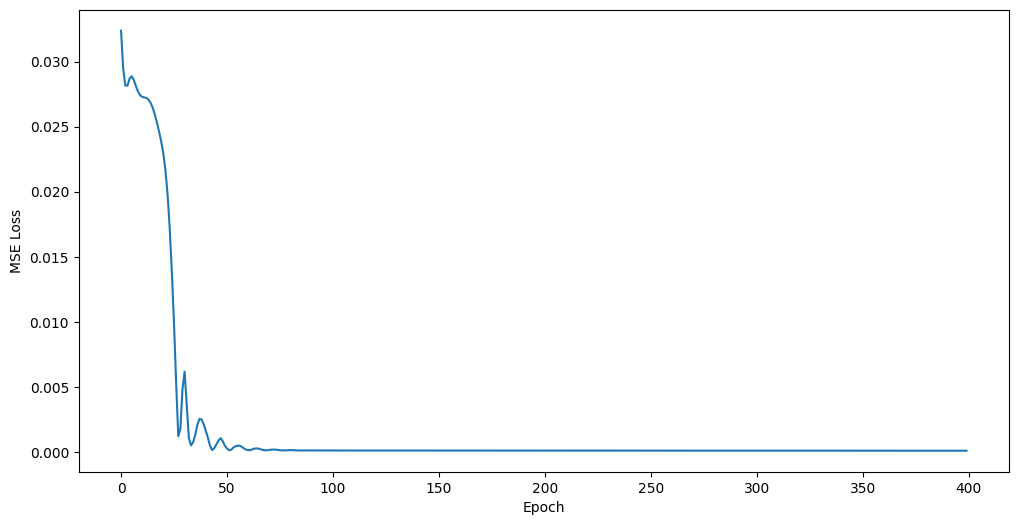

In [15]:
#visualize loss throughout training
plt.figure(figsize=(12, 6))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.plot(list(range(epochs)), train_loss)

# Load the Best Model

In [16]:
best_model = LSTM(input_size, hidden_dim, num_layers, output_dim).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))

<ipython-input-16-3d22f3f71c29>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [17]:
#get predictions
gru_predictions = model(X_test.to(device))
test_loss = loss_func(gru_predictions, y_test.to(device))
gru_predictions = gru_predictions.squeeze().tolist()

# Reverse Normalize

In [18]:
min = min_max_dictionary['Close'][0]
max = min_max_dictionary['Close'][1]

#reverse normalize predictions and dataset values
gru_predictions = [reverse_normalize(x, min, max) for x in np.array(gru_predictions)]

stock_value = [reverse_normalize(x, min, max) for x in np.array(stock_value)]

# Visualizing and Testing Model

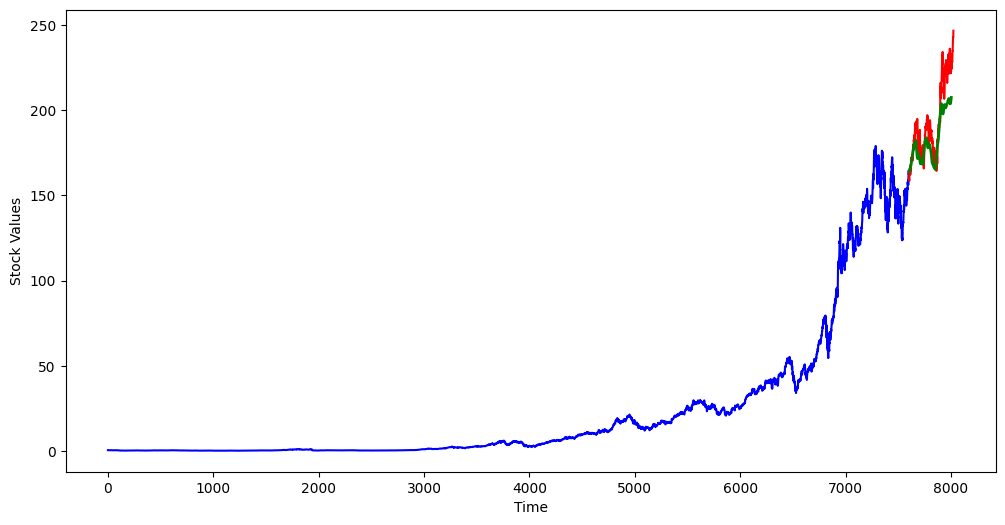

In [19]:
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(X_train.size(0))], stock_value[:X_train.size(0)], color='b', label='trained values')

#plot test range and predictions by the GRU
time_values_actual = list(range(X_train.size(0), len(stock_value)))
time_values_pred = list(range(X_train.size(0), X_train.size(0) + y_test.size(0)))
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.plot(time_values_actual, stock_value[-len(time_values_actual):], color='r', label='actual values')
plt.plot(time_values_pred[3:], gru_predictions[3:], color='g', linewidth=2, label='predicted values')

plt.show()

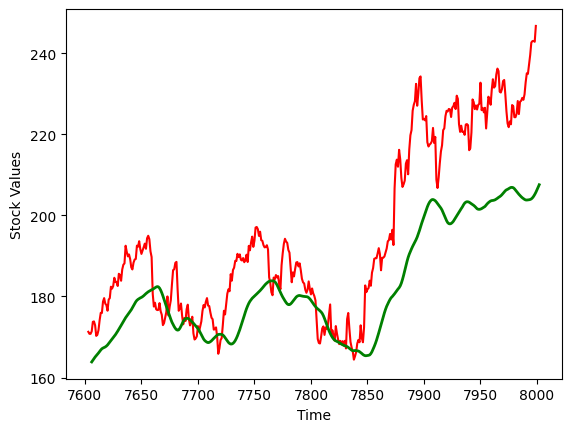

In [20]:
#closer plot test range and predictions by the GRU
time_values_actual = list(range(X_train.size(0), X_train.size(0) + y_test.size(0) - 3 ))
time_values_pred = list(range(X_train.size(0), X_train.size(0) + y_test.size(0)))
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.plot(time_values_actual, stock_value[-len(time_values_actual):], color='r', label='actual values')
plt.plot(time_values_pred[3:], gru_predictions[3:], color='g', linewidth=2, label='predicted values')

plt.show()

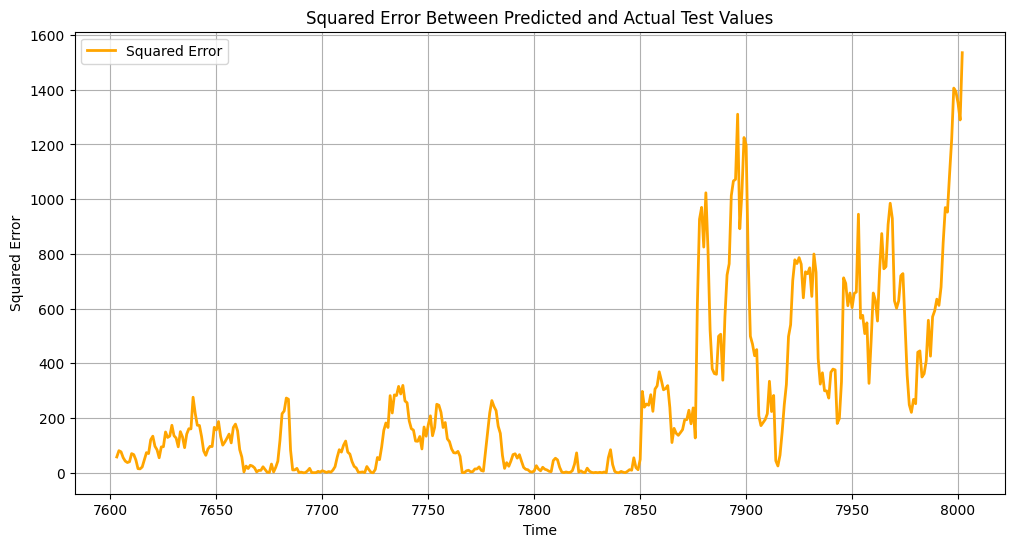

In [21]:
# Plot the squared error for the test set
# Compute the squared errors between predictions and actual values
squared_errors = [(pred - actual) ** 2 for pred, actual in zip(gru_predictions, stock_value[-len(gru_predictions):])]

plt.figure(figsize=(12, 6))

time_values_pred = list(range(X_train.size(0), X_train.size(0) + len(squared_errors)))
plt.plot(time_values_pred, squared_errors, color='orange', label='Squared Error', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Squared Error')
plt.title('Squared Error Between Predicted and Actual Test Values')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
import math
squared_errors = [(pred - actual)**2 for pred, actual in zip(gru_predictions, stock_value[-len(gru_predictions):])]

# Tính toán MSE
mse = sum(squared_errors) / len(squared_errors)

# Tính toán RMSE
rmse = math.sqrt(mse)

# In ra giá trị RMSE
print('RMSE:', rmse)

RMSE: 15.982310318644945


<ipython-input-22-64a659f8c7d1>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(mse)
